# ` Binary Classification ` Model Creation

## Scope

A more statistical approach was taken from previous notebook.

### Imports

In [1]:
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statistics

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


import imblearn
from imblearn.over_sampling import SMOTE

import pickle as pk

In [2]:
print(f'pandas:{pd.__version__}')
print(f'numpy:{np.__version__}')
print(f'sklearn:{sklearn.__version__}')
print(f'imblearn:{imblearn.__version__}')
print(f'seaborn:{sns.__version__}')
print(f'python:{sys.version}')

pandas:2.0.1
numpy:1.23.5
sklearn:1.2.2
imblearn:0.10.1
seaborn:0.12.2
python:3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


## Path

<ins>**Change the BASE path to your folder location**</ins>

In [3]:
BASE = r"C:\\Users\\anand\\Documents\\HE_Performance_3b"

PROCESSED = BASE + r"\\data\\processed\\"

EXPORT = BASE + r"\\data\\model\\"

## Read Data

In [4]:
# Read parquet
df = pd.read_parquet(PROCESSED + r"student_data.pqt")

# Preview
df.head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,total_salary,transport_uni,acc_type,...,prep_friends,prep_freq,notes,listening,discussion,flip-classroom,cgpa_last_sem,cgpa_expected,course_id,grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


In [5]:
# Shape of data
df.shape

(145, 32)

In [6]:
# Unique values and counts of grade
df.grade.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

We will be defining the problem statement as a **binary classication** problem which will help us get a better accuracy for predicting student performance.

> **We predict which student is going to get high grades and pass by combining the grades 6-7 as 1 (`High Performing Students`) and 0-5 as 0 (`Non-High Performing Students`), which then becomes a binary classification problem.**

The goal is to accurately predict which students perform highly or not.

In [7]:
# Assigning labels
label = {
    6:1,
    7:1,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
}

# Replace labels
df['grade'] = df.grade.replace(label)

# Count of unique values
df.grade.value_counts()

grade
0    115
1     30
Name: count, dtype: int64

Now we have 30 High performing students in dataset, and remaining are non-high performing students.

In [8]:
# Train-test 
X = df.drop('grade',axis=1)
y = df['grade']

In [9]:
# Resetting indices
X = X.reset_index(drop=True)
y= y.reset_index(drop=True)


## Encoding

In [10]:
# Columns list
X.columns

Index(['age', 'sex', 'grad_hs', 'scholar_type', 'add_work', 'reg_art_sport',
       'partner', 'total_salary', 'transport_uni', 'acc_type', 'mother_edu',
       'father_edu', 'siblings', 'parental', 'mother_occ', 'father_occ',
       'weekly_study_hours', 'rf_non_scientific', 'rf_scientific',
       'attendance_seminar', 'impact', 'attendance_classes', 'prep_friends',
       'prep_freq', 'notes', 'listening', 'discussion', 'flip-classroom',
       'cgpa_last_sem', 'cgpa_expected', 'course_id'],
      dtype='object')

The ordinal columns are already in numerical format. But some features do not have the correct ranking such as:-

`impact`

`attendance_classes`

`prep_freq`

In [11]:
# Ordinal columns that need to be correctly ranked
incorrect_ordinal = [
    'impact',
    'attendance_classes',
    'prep_freq'
]

# Preview
X[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,2
4,1,1,1


In [12]:
# Correctly ranking ordinal columns
X['impact'] = X.impact.replace({2:1,3:2,1:3})


X['attendance_classes'] = X.attendance_classes.replace({3:1,1:3})


X['prep_freq'] = X.prep_freq.replace({3:1,1:2,2:3})

# Preview
X[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,3,3,2
1,3,3,2
2,3,3,2
3,3,3,3
4,3,3,2


The nominal columns have to be encoded using `OneHotEncoding`.

**OneHotEncoding will be done on training dataset first, then the same transformation will be applied to test data. This is to maintain feature consistency and prevent information leakage.**

In [13]:
# Nominal columns
nominal = [
    'age',
    'sex',
    'grad_hs',
    'scholar_type',
    'add_work',
    'reg_art_sport',
    'partner',
    'transport_uni',
    'acc_type',
    'parental',
    'mother_occ',
    'father_occ',
    'attendance_seminar',
    'prep_friends',
    'prep_freq',
    'flip-classroom',
    'course_id'
    
]

# Preview
X[nominal].head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,transport_uni,acc_type,parental,mother_occ,father_occ,attendance_seminar,prep_friends,prep_freq,flip-classroom,course_id
0,2,2,3,3,1,2,2,1,1,1,2,5,1,1,2,2,1
1,2,2,3,3,1,2,2,1,1,1,2,1,1,1,2,2,1
2,2,2,2,3,2,2,2,4,2,1,2,1,1,1,2,1,1
3,1,1,1,3,1,2,1,1,2,1,2,1,1,1,3,1,1
4,2,2,1,3,2,2,1,1,4,1,2,4,1,2,2,1,1


In [14]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [15]:
# Created one hot encoded array
nom_array = ohe.fit_transform(X[nominal]).toarray()

# Preview
nom_array

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [16]:
# Names of encoded features
ohe.get_feature_names_out()

array(['age_1', 'age_2', 'age_3', 'sex_1', 'sex_2', 'grad_hs_1',
       'grad_hs_2', 'grad_hs_3', 'scholar_type_1', 'scholar_type_2',
       'scholar_type_3', 'scholar_type_4', 'scholar_type_5', 'add_work_1',
       'add_work_2', 'reg_art_sport_1', 'reg_art_sport_2', 'partner_1',
       'partner_2', 'transport_uni_1', 'transport_uni_2',
       'transport_uni_3', 'transport_uni_4', 'acc_type_1', 'acc_type_2',
       'acc_type_3', 'acc_type_4', 'parental_1', 'parental_2',
       'parental_3', 'mother_occ_1', 'mother_occ_2', 'mother_occ_3',
       'mother_occ_4', 'mother_occ_5', 'father_occ_1', 'father_occ_2',
       'father_occ_3', 'father_occ_4', 'father_occ_5',
       'attendance_seminar_1', 'attendance_seminar_2', 'prep_friends_1',
       'prep_friends_2', 'prep_friends_3', 'prep_freq_1', 'prep_freq_2',
       'prep_freq_3', 'flip-classroom_1', 'flip-classroom_2',
       'flip-classroom_3', 'course_id_1', 'course_id_2', 'course_id_3',
       'course_id_4', 'course_id_5', 'course_id_6'

In [17]:
# Drop original nominal columns
X = X.drop(nominal, axis = 1)
 
# Preview
X.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,listening,discussion,cgpa_last_sem,cgpa_expected
0,1,1,2,3,3,2,2,3,3,3,2,1,1,1
1,1,2,3,2,2,2,2,3,3,3,2,3,2,3
2,2,2,2,2,2,1,2,3,3,2,2,1,2,2
3,2,1,2,5,3,1,2,3,3,3,2,2,3,2
4,3,3,3,2,2,1,1,3,3,2,2,2,2,2


In [18]:
# Encoded columns
nom_df = pd.DataFrame(nom_array,columns = ohe.get_feature_names_out())

# Preview
nom_df.head()

,age_1,age_2,age_3,sex_1,sex_2,grad_hs_1,grad_hs_2,grad_hs_3,scholar_type_1,scholar_type_2,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Concat to original dataset
X = pd.concat([X,nom_df], axis=1)

# Preview
X.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,1,1,2,3,3,2,2,3,3,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,3,2,2,2,2,3,3,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,2,2,2,1,2,3,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,1,2,5,3,1,2,3,3,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3,3,2,2,1,1,3,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ## Feature Selection

In [20]:
# Take subset of columns based on domain knowledge
best = [
    'course_id_1',
    'course_id_2',
    'course_id_4',
    'course_id_5',
    'sex_1',
    'sex_2',
    'age_1',
    'age_2',
    'age_3',
    'course_id_7',
    'course_id_3',
    'course_id_6',
    'course_id_9',
    'course_id_8',
    'cgpa_expected'
]

In [21]:
# Perform chi-square test
f_p_values = chi2(X[best],y)

# Preview p-values
pd.DataFrame(f_p_values[1])

,0
0,3.333705e-05
1,4.701008e-01
2,8.314719e-01
3,1.476587e-01
4,9.509005e-03
5,3.423174e-02
6,8.914511e-02
7,1.859418e-01
8,4.040038e-01
9,2.825306e-10


In [22]:
# Preview significant features
b = pd.DataFrame(best, columns = ['Features'])

b['F-scores'] = f_p_values[0]

b['p_values'] = f_p_values[1]

b['Significant'] = np.where(b.p_values<0.05,True,False)

In [23]:
b.sort_values('p_values',ascending=True)

,Features,F-scores,p_values,Significant
9,course_id_7,39.791787,2.825306e-10,True
11,course_id_6,21.761775,3.086894e-06,True
0,course_id_1,17.217391,3.333705e-05,True
10,course_id_3,14.380435,1.493460e-04,True
4,sex_1,6.724638,9.509005e-03,True
12,course_id_9,5.478261,1.925441e-02,True
5,sex_2,4.483092,3.423174e-02,True
13,course_id_8,3.652174,5.599608e-02,False
6,age_1,2.889744,8.914511e-02,False
3,course_id_5,2.096273,1.476587e-01,False


In [24]:
# Select significant features
best = [
    'course_id_1',
    'sex_1',
    'course_id_7',
    'course_id_3',
    'course_id_6',
    'course_id_9',
]

In [25]:
# Filtering features
X = X[best]

X = X[best]

X.head()

,course_id_1,sex_1,course_id_7,course_id_3,course_id_6,course_id_9
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

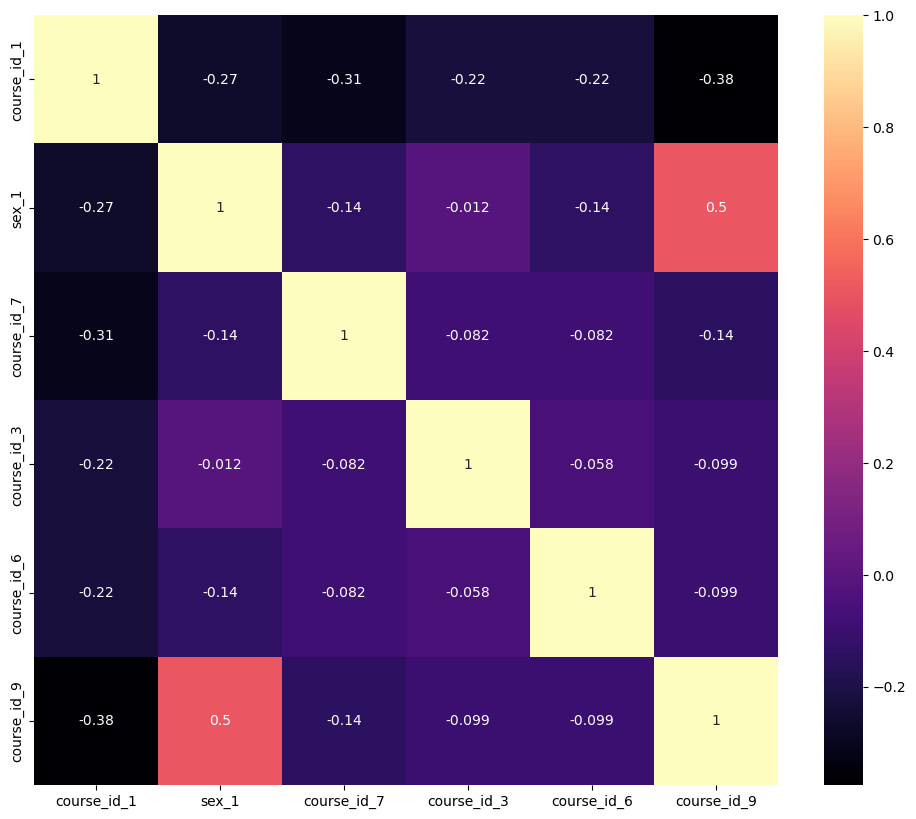

In [26]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(),annot=True,cmap='magma')

## Modelling

We will be first testing multiple classifier models to compare.

In [27]:
# List of models to compare
models = {
    'Logistic Regression':LogisticRegression(random_state=43),
    'Linear SVC':LinearSVC(random_state=45),
    'Decision Tree':DecisionTreeClassifier(random_state=43),
    'K-nearest Neighbhour':KNeighborsClassifier(),
    'Random Forest':RandomForestClassifier(random_state=43)
}

score = {}
train_score = []

In [28]:
from sklearn.model_selection import StratifiedKFold

for i in range(len(list(models))):

        #Select model
        model = list(models.values())[i]

        # Train model
        model.fit(X,y)

        # Make predictions
        y_train_pred = model.predict(X)
        y_test_pred = model.predict(X)



        print('Model performance for training set \n')

        print(f" Training performance of {list(models.keys())[i]}: \n",classification_report(y, y_train_pred))

        print('Model performance for testing set \n')

        print(f" Testing performance of {list(models.keys())[i]}: \n",classification_report(y, y_test_pred))

        print("ROC-AUC score:",round(roc_auc_score(y,y_test_pred),3))

        print('='*35)

        # Store test score in dictionary
        score[list(models.keys())[i]] = round(classification_report(y, y_test_pred,output_dict=True)['macro avg']['f1-score'],2)

        # Get train score
        train_score.append(round(classification_report(y, y_train_pred,output_dict=True)['macro avg']['f1-score'],2))

Model performance for training set 

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       115
           1       0.92      0.73      0.81        30

    accuracy                           0.93       145
   macro avg       0.93      0.86      0.89       145
weighted avg       0.93      0.93      0.93       145

Model performance for testing set 

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       115
           1       0.92      0.73      0.81        30

    accuracy                           0.93       145
   macro avg       0.93      0.86      0.89       145
weighted avg       0.93      0.93      0.93       145

ROC-AUC score: 0.858
Model performance for training set 

 Training performance of Linear SVC: 
               precision    recall  f1-score   support

           0       0.96   

**Metric - F1 score**

- I chose **F1 score** as our metric since accuracy is a poor metric for unbalanced data. 

- F1-score was chosen over precison or recall since in this use case, we are equally interested in minimising False Positives and False Negatives.

- I specifically chose **macro average of F1-score** since the f1-score for each individual class is varying significantly. For weighted average, resulting performance is based on the proportion of every class. So in order to prevent f1 score of one class significantly biasing the average, i chose macro average since it does not consider the proportion of classes.

In [29]:
# Convert test accuracy to dataframe
m_acc = pd.DataFrame(score.items(),columns = ['model','test_f1_score']).sort_values('test_f1_score',ascending=False)

# Append list to column
m_acc['train_f1_score'] = train_score

# Preview
m_acc

,model,test_f1_score,train_f1_score
1,Linear SVC,0.91,0.89
2,Decision Tree,0.91,0.91
4,Random Forest,0.91,0.91
0,Logistic Regression,0.89,0.89
3,K-nearest Neighbhour,0.89,0.91


### Final Model

I chose to do hyperparameter tuning manually and found that the simple default values worked best.

A `L2 Regularization` is done when fitting the model which will help in reducing overfitting and doing feature selection. It will also handle multicollinearity between features. 

In [30]:
# Performing cross validation
train_score=[]
test_score=[]
roc=[]

k=5
# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=43)

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # SMOTE sampling
    ros = SMOTE(sampling_strategy='auto',k_neighbors=2,random_state=43)

    # Resample dataest
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Linear SVC
    lsvc = LogisticRegression(penalty = 'l2', intercept_scaling=1, C=1,max_iter=100000, random_state=43)

    # Train model
    lsvc.fit(X_train,y_train)

    # Make predictions
    y_train_pred = lsvc.predict(X_train)
    y_test_pred = lsvc.predict(X_test)
    
    train_score.append(round(classification_report(y_train, y_train_pred,output_dict=True)['macro avg']['f1-score'],2))
    test_score.append(round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2))
    roc.append(round(roc_auc_score(y_test,y_test_pred),3))

    print("Training f1-score :",round(classification_report(y_train, y_train_pred,output_dict=True)['macro avg']['f1-score'],2))

    print("Testing f1-score :",round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2))

    print("ROC-AUC score:",round(roc_auc_score(y_test,y_test_pred),3))

Training f1-score : 0.93
Testing f1-score : 0.87
ROC-AUC score: 0.935
Training f1-score : 0.95
Testing f1-score : 0.79
ROC-AUC score: 0.891
Training f1-score : 0.93
Testing f1-score : 0.87
ROC-AUC score: 0.935
Training f1-score : 0.93
Testing f1-score : 0.91
ROC-AUC score: 0.957
Training f1-score : 0.93
Testing f1-score : 0.91
ROC-AUC score: 0.957


In [31]:
# Training scores
train_score

[0.93, 0.95, 0.93, 0.93, 0.93]

In [32]:
# Mean training score
sum(train_score)/k

0.9339999999999999

In [33]:
# Standard deviation of training score
statistics.stdev(train_score)

0.008944271909999116

In [34]:
# Testing scores
test_score

[0.87, 0.79, 0.87, 0.91, 0.91]

In [35]:
# Mean test score
sum(test_score)/k

0.8700000000000001

In [36]:
# Standard deviation of test score
statistics.stdev(test_score)

0.04898979485566356

In [37]:
# Mean ROC-AUC score
sum(roc)/5

0.9349999999999999

In [38]:
# Coefficients of features
coef= pd.DataFrame(best, columns = ['features'])

coef['coefficients'] = lsvc.coef_[0]

coef.sort_values('coefficients', key=abs, ascending=False)

,features,coefficients
0,course_id_1,-2.793231
2,course_id_7,2.239518
1,sex_1,-1.944802
3,course_id_3,1.874068
4,course_id_6,1.787281
5,course_id_9,-1.125066


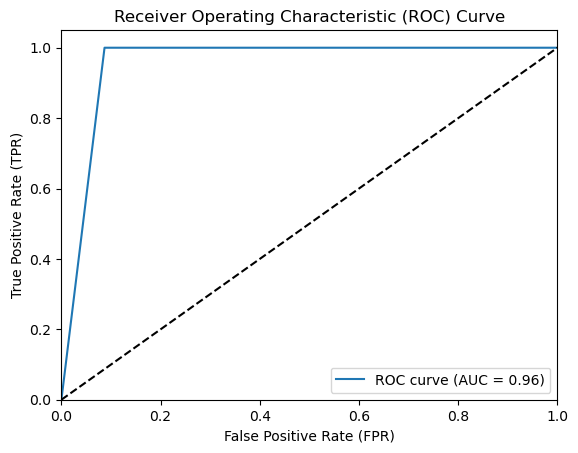

In [39]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Export model

In [40]:
# Model filename
filename = r'binary_model.pickle'

In [41]:
# Export file
pk.dump(lsvc, open(EXPORT+filename, 'wb'))